In [1]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from tools.utils import set_seed
import numpy as np
import tensorflow_model_optimization as tfmot

set_seed(1234)

2023-08-27 17:57:44.438893: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-27 17:57:44.497059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 17:57:45.069497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset
Create and load dataset. Split dataset into train-validation-test with 0.8, 0.1, 0.1 percentages

In [2]:
dataset_name = DatasetName.RADIOML_2016
radioml2016b_path = cur_dir + "/data/radioml_2016/RML2016.10b.dat"
radioml2016a_path = cur_dir + "/data/radioml_2016/RML2016.10a_dict.pkl"
dataset_path = os.path.abspath(radioml2016b_path)
radioml_ds = make_sigmod_ds(dataset_name)
radioml_ds.load(dataset_path, normalize=True)
splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)
print(f"Modulations: {radioml_ds.get_modulations()}")

In [ ]:
# idx = 1000

# print(radioml_ds.get_data()[idx].shape)
# print(np.min(radioml_ds.get_data()[idx]))
# print(np.max(radioml_ds.get_data()[idx]))
# print(np.mean(radioml_ds.get_data()[idx]))

# print(radioml_ds.get_data().shape)
# print(np.min(radioml_ds.get_data()))
# print(np.max(radioml_ds.get_data()))
# print(np.mean(radioml_ds.get_data()))
# print(np.std(radioml_ds.get_data()))

# Create Model
Create convolutional model

In [ ]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName
from evaluation.results_serialization import load_results

model_name = "cnn_1d_v012_small_radio_ml16b_normalized"
train_model = True
q_aware = True

quantize_model = tfmot.quantization.keras.quantize_model

if train_model:
    cnn_1d_v012_3_configuration = Convolution01xConfiguration(
        input_shape=(128, 2),
        n_classes=len(radioml_ds.get_modulations()),
        output_channels=[32, 48, 64, 96],
        kernel_sizes=[8, 8, 8, 8],
        paddings=["same", "same", "same", "same",],
        max_pool_sizes=[1, 2, 2, 1],
        max_pool_strides=[1, 2, 2, 1],
        avg_size=32,
        dense_sizes=[96],
    )

    model_configuration = cnn_1d_v012_3_configuration

    model = make_sigmod_model(ModelName.CNN_1D_V012, model_configuration)

    model.summary()

else:
    results = load_results(model_name + "_results/", load_model=True)
    model = results["model"]
    
if q_aware:
    model = quantize_model(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 CNN0_ (Conv1D)              (None, 128, 32)           544       
                                                                 
 MAX_POOL_0_ (MaxPooling1D)  (None, 128, 32)           0         
                                                                 
 BN0_ (CustomBatchNorm)      (None, 128, 32)           128       
                                                                 
 CNN_REL0_ (ReLU)            (None, 128, 32)           0         
                                                                 
 CNN1_ (Conv1D)              (None, 128, 48)           12336     
                                                                 
 MAX_POOL_1_ (MaxPooling1D)  (None, 64, 48)            0     

2023-08-14 00:15:30.651288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 00:15:30.676978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 00:15:30.677116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

ValueError: Unable to clone model. This generally happens if you used custom Keras layers or objects in your model. Please specify them via `quantize_scope` for your calls to `quantize_model` and `quantize_apply`. [Unknown layer: 'CustomBatchNorm'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.].

# Train model
Train model with Adam optimizer + lr decay + SparseCategoricalCrossentropy loss

In [ ]:
import tensorflow as tf

def step_decay(epoch):
    # lrate = 0.001
    # factor = epoch // 8
    # lrate /= 10**factor
    return 0.001
    lrate = 0.001
    if epoch >= 16:
        lrate /= 10
    if epoch >= 24:
        lrate /= 4
    if epoch >= 32:
        lrate /= 4
    if epoch >= 40:
        lrate /= 2
    # factor = epoch // 8
    # lrate /= 10**factor
    return lrate


if train_model:
    lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    # N_EPOCHS = 16
    # N_EPOCHS = 48
    # N_EPOCHS = 20
    N_EPOCHS = 7
    BATCH_SIZE = 256

    h = model.fit(
        splitted_radioml_ds.train.data,
        splitted_radioml_ds.train.labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
        callbacks=[lrate]
    )


Epoch 1/7


2023-08-13 19:44:52.072780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-13 19:44:52.631490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-13 19:44:52.645248: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f5884c0d270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-13 19:44:52.645267: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2023-08-13 19:44:52.662406: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-13 19:44:52.824191: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lif

3750/3750 [==============================] - 23s 5ms/step - loss: 1.3853 - accuracy: 0.4561 - val_loss: 1.1184 - val_accuracy: 0.5592 - lr: 0.0010
Epoch 2/7
3750/3750 [==============================] - 19s 5ms/step - loss: 1.0375 - accuracy: 0.5947 - val_loss: 0.9996 - val_accuracy: 0.6085 - lr: 0.0010
Epoch 3/7
3750/3750 [==============================] - 19s 5ms/step - loss: 0.9722 - accuracy: 0.6203 - val_loss: 0.9659 - val_accuracy: 0.6219 - lr: 0.0010
Epoch 4/7
3750/3750 [==============================] - 20s 5ms/step - loss: 0.9352 - accuracy: 0.6359 - val_loss: 0.9467 - val_accuracy: 0.6320 - lr: 0.0010
Epoch 5/7
3750/3750 [==============================] - 20s 5ms/step - loss: 0.9120 - accuracy: 0.6454 - val_loss: 0.9370 - val_accuracy: 0.6347 - lr: 0.0010
Epoch 6/7
3750/3750 [==============================] - 20s 5ms/step - loss: 0.8955 - accuracy: 0.6522 - val_loss: 0.8805 - val_accuracy: 0.6582 - lr: 0.0010
Epoch 7/7
3750/3750 [==============================] - 20s 5ms/step 

# Evaluation
Check train plots, confusion matrices, snr to accuracy

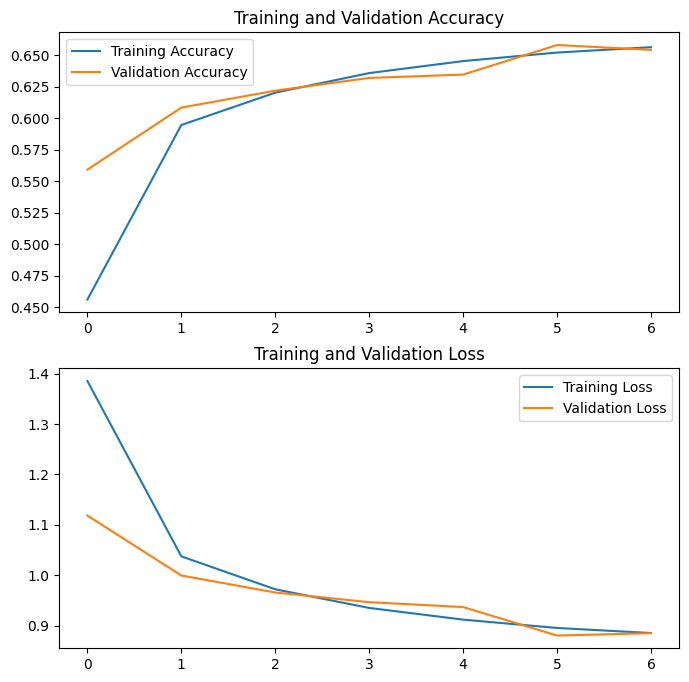

In [6]:
if train_model:
    from evaluation.vizualization import plot_train, plot_snr_to_acc
    plot_train(h.history)

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.6581666666666667}
8PSK test accuracy: 0.5545341614906832
AM-DSB test accuracy: 0.670806942502262
BPSK test accuracy: 0.7889036987670777
CPFSK test accuracy: 0.7555242903252504
GFSK test accuracy: 0.6956665838097605
PAM4 test accuracy: 0.7114981994807805
QAM16 test accuracy: 0.7291526563550773
QAM64 test accuracy: 0.7087314114812661
QPSK test accuracy: 0.6336549133441475
WBFM test accuracy: 0.33355509355509355
Confusion matrix:
[[6696  543  638 1417  188  144  589  299 1473   88]
 [ 175 8155 1042  870  250   32   61   26  708  838]
 [ 156  326 9470  654  129  399  106   24  664   76]
 [ 227  442  947 9129  281   52  134   30  796   45]
 [ 111  664  816 1028 8396   36   81   20  691  226]
 [ 342  256 1152  629  141 8496  230   59  560   76]
 [ 315  202  699  713  141  118 8674  339  646   49]
 [ 467  151  229  720   69  137 1131 8531  557   45]
 [ 357  445 1166 1241  230   75  451  289 7422   37]
 [ 287 4662 1171  678  351   

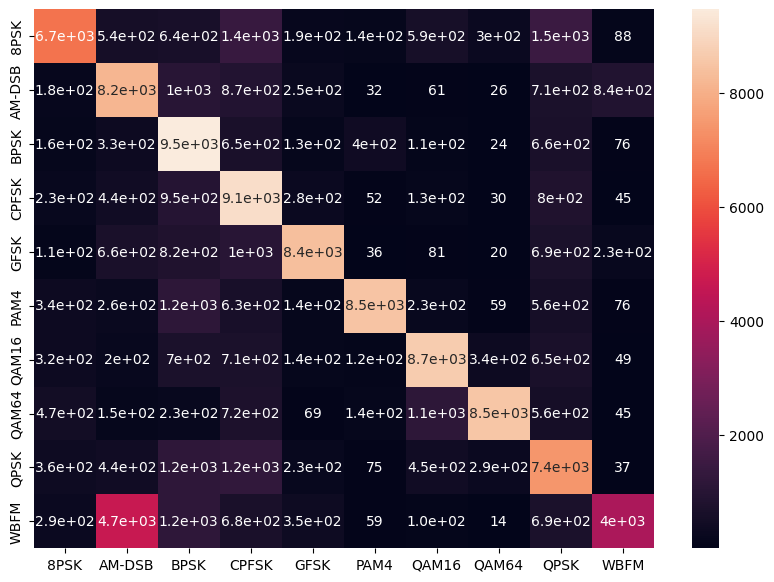

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.6542666666666667}
8PSK test accuracy: 0.5476210246616292
AM-DSB test accuracy: 0.6647273936170213
BPSK test accuracy: 0.7912762252259723
CPFSK test accuracy: 0.7476277676044615
GFSK test accuracy: 0.6879715181825888
PAM4 test accuracy: 0.7175787728026534
QAM16 test accuracy: 0.7319048422473426
QAM64 test accuracy: 0.7097487108128019
QPSK test accuracy: 0.6150962259435141
WBFM test accuracy: 0.32673433436792215
Confusion matrix:
[[6595  575  657 1435  174  139  602  274 1482  110]
 [ 189 7998 1017  806  259   46   69   19  713  916]
 [ 134  292 9542  645  123  421  112   21  700   69]
 [ 255  476 1008 8982  289   45  117   33  761   48]
 [ 118  663  851 1043 8116   35   72   10  692  197]
 [ 326  259 1169  579  132 8654  227   67  574   73]
 [ 324  211  678  698  134  124 8676  304  670   35]
 [ 475  166  192  748   74  177 1185 8671  490   39]
 [ 331  471 1250 1365  272   65  538  283 7383   45]
 [ 254 4701 1176  664  363  

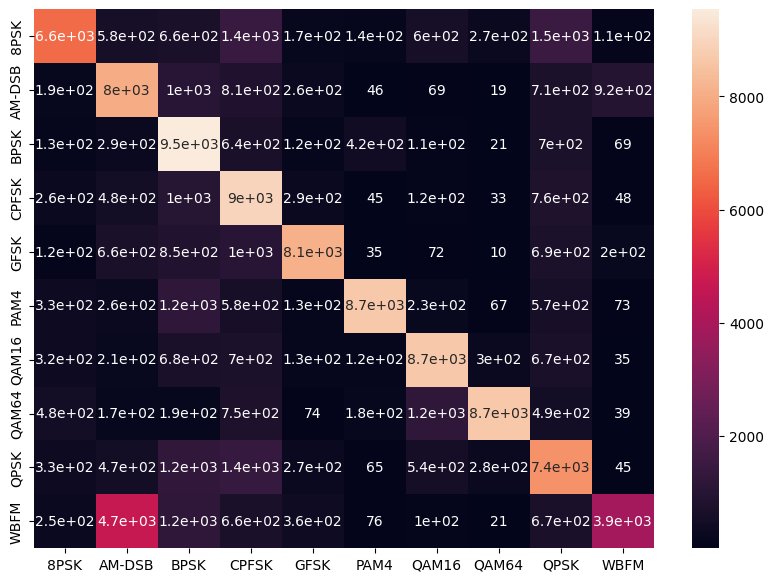

In [7]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation

cm_test, cls_to_acc_test = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_modulations(),
)

SNR: -20 -- Overall test accuracy: 0.19887770259118667
SNR: -18 -- Overall test accuracy: 0.17220744680851063
SNR: -16 -- Overall test accuracy: 0.1650729743331656
SNR: -14 -- Overall test accuracy: 0.23097552799195442
SNR: -12 -- Overall test accuracy: 0.21562448167191905
SNR: -10 -- Overall test accuracy: 0.342685370741483
SNR: -8 -- Overall test accuracy: 0.4503333333333333
SNR: -6 -- Overall test accuracy: 0.5883649932157394
SNR: -4 -- Overall test accuracy: 0.7730520019936866
SNR: -2 -- Overall test accuracy: 0.8016542597187758
SNR: 0 -- Overall test accuracy: 0.90799471423852
SNR: 2 -- Overall test accuracy: 0.8857668506439204
SNR: 4 -- Overall test accuracy: 0.9147530150338675
SNR: 6 -- Overall test accuracy: 0.9345668629100085
SNR: 8 -- Overall test accuracy: 0.9337638681900977
SNR: 10 -- Overall test accuracy: 0.9179648657606895
SNR: 12 -- Overall test accuracy: 0.9365106382978723
SNR: 14 -- Overall test accuracy: 0.9318787475016655
SNR: 16 -- Overall test accuracy: 0.92726968

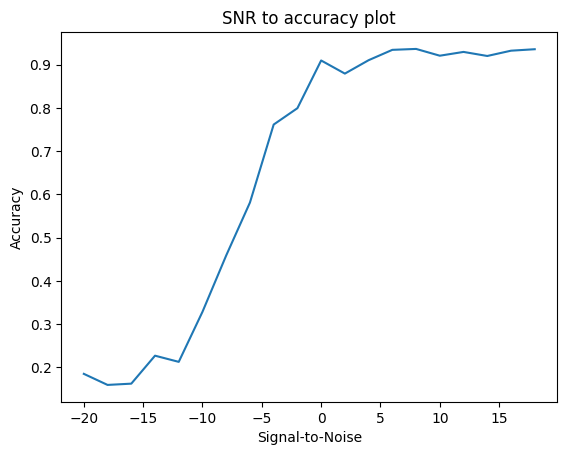

In [8]:
snr_to_acc_test = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)
snr_to_acc_val = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().val],
)
plot_snr_to_acc(snr_to_acc_val)

# Save results

In [10]:
# reload_module("evaluation.results_serialization")
from evaluation.results_serialization import dump_results

from copy import deepcopy

history = deepcopy(h.history)
history["lr"] = list(map(lambda x: float(x), history["lr"]))
# history = {}

dump_results(
    model_name + "_results/",
    model=model,
    model_config=model_configuration,
    model_name=ModelName.CNN_1D_V012,
    dataset_name=DatasetName.RADIOML_2016,
    dataset_path=dataset_path,
    train_history=history,
    cm_test=cm_test,
    cls_to_acc_test=cls_to_acc_test,
    snr_to_acc_test=snr_to_acc_test,
    cm_val=cm_val,
    cls_to_acc_val=cls_to_acc_val,
    snr_to_acc_val=snr_to_acc_val,
    short_description="Smaller + dense, 48 epochs with more decay (16:/=10, 24:/=4, 32: /=4)",
    dump_model=True,
)

# TF lite
Convert model to TF lite with/without quantization, and evaluate

1. No quantization

INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml16b_1_results/model_original/assets


INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml16b_1_results/model_original/assets
2023-08-12 00:17:22.999748: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-12 00:17:22.999771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-12 00:17:22.999912: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v012_small_radio_ml16b_1_results/model_original
2023-08-12 00:17:23.001282: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-12 00:17:23.001292: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v012_small_radio_ml16b_1_results/model_original
2023-08-12 00:17:23.005129: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-12 00:17:23.033847: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel 

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.6368}
8PSK test accuracy: 0.6693995859213251
AM-DSB test accuracy: 0.6782100847248499
BPSK test accuracy: 0.6554481839386871
CPFSK test accuracy: 0.6663907969875031
GFSK test accuracy: 0.7834949043002735
PAM4 test accuracy: 0.7086508667615777
QAM16 test accuracy: 0.5679219905850706
QAM64 test accuracy: 0.7001744620752679
QPSK test accuracy: 0.5972850678733032
WBFM test accuracy: 0.3384615384615385
Confusion matrix:
[[8083  206  512  480 1275  141  210  343  656  169]
 [ 849 8245  266  195  958   40   12   20  174 1398]
 [1214  229 7868  387 1141  481   62   83  395  144]
 [1287  226  421 8052 1292  109   81  111  348  156]
 [ 962  295  340  308 9456   75   28   45  260  300]
 [ 882  174  760  292  823 8462   56   97  291  104]
 [1206  126  362  320  792  110 6756 1682  451   91]
 [ 804   72  257  274  506  105 1182 8428  349   60]
 [1664  229  492  478 1162  122  172  260 6996  138]
 [ 805 5187  300  184 1171   53   19   22

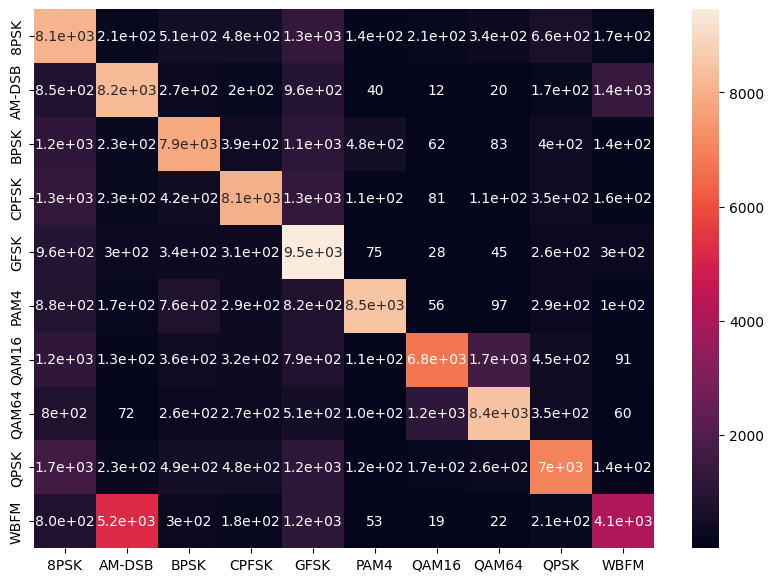

SNR: -20 -- Overall test accuracy: 0.10777355999339826
SNR: -18 -- Overall test accuracy: 0.11353058510638298
SNR: -16 -- Overall test accuracy: 0.12514678745176983
SNR: -14 -- Overall test accuracy: 0.16258799865906806
SNR: -12 -- Overall test accuracy: 0.2292254105158401
SNR: -10 -- Overall test accuracy: 0.3062792251169005
SNR: -8 -- Overall test accuracy: 0.4081666666666667
SNR: -6 -- Overall test accuracy: 0.5569877883310719
SNR: -4 -- Overall test accuracy: 0.7182256188735671
SNR: -2 -- Overall test accuracy: 0.8269644334160463
SNR: 0 -- Overall test accuracy: 0.885199867855963
SNR: 2 -- Overall test accuracy: 0.9108546579695601
SNR: 4 -- Overall test accuracy: 0.9190484057492153
SNR: 6 -- Overall test accuracy: 0.9236333052985702
SNR: 8 -- Overall test accuracy: 0.9246564000662362
SNR: 10 -- Overall test accuracy: 0.9186277759363606
SNR: 12 -- Overall test accuracy: 0.9266382978723404
SNR: 14 -- Overall test accuracy: 0.9238840772818121
SNR: 16 -- Overall test accuracy: 0.922922

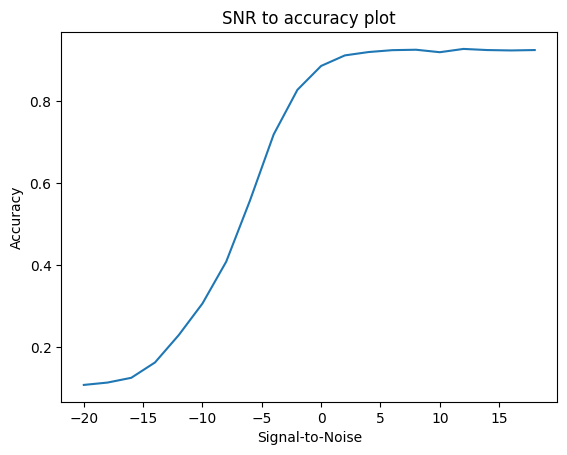

In [7]:
from deployment_tools import to_tf_lite, predict_tflite
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_snr_to_acc

model_path = f"{model_name}_results/model_original"
model.save(model_path)

model_tflile_no_quant = to_tf_lite(model_path, apply_quantization=False)

cm_test_tflite_no_quant, cls_to_acc_test_tflite_no_quant = metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite_no_quant = snr_to_metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite_no_quant)

2023-08-12 00:21:41.886854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-12 00:21:41.886879: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-12 00:21:41.887037: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v012_small_radio_ml16b_1_results/model_original
2023-08-12 00:21:41.888571: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-12 00:21:41.888584: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v012_small_radio_ml16b_1_results/model_original
2023-08-12 00:21:41.892674: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-12 00:21:41.922947: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: cnn_1d_v012_small_radio_ml16b_1_results/model_original
2023-08-12 00:21:41.932638

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.5154583333333334}
8PSK test accuracy: 0.6540786749482401
AM-DSB test accuracy: 0.7727235337665542
BPSK test accuracy: 0.6334555148283906
CPFSK test accuracy: 0.5823884796821981
GFSK test accuracy: 0.39067031237053607
PAM4 test accuracy: 0.6403986265806884
QAM16 test accuracy: 0.5450571620712845
QAM64 test accuracy: 0.13608041870898063
QPSK test accuracy: 0.546486809527875
WBFM test accuracy: 0.2525571725571726
Confusion matrix:
[[7898 1268  690  176  458  100   97   17 1153  218]
 [1596 9394  149   16  251   10    4    0   76  661]
 [2301 1166 7604   31  415  210   17    0  175   85]
 [2205 1453  389 7037  442   63   30    0  278  186]
 [1956 1863  205   35 4715   30    8    1   90 3166]
 [1663 1027 1015   23  350 7647   21    0  119   76]
 [2037 1064  612  111  322  217 6484  141  707  201]
 [1287  886  553  103  200  194 6359 1638  651  166]
 [2451 1300  676  130  427   94   57    2 6401  175]
 [1676 6815  147   16  231  

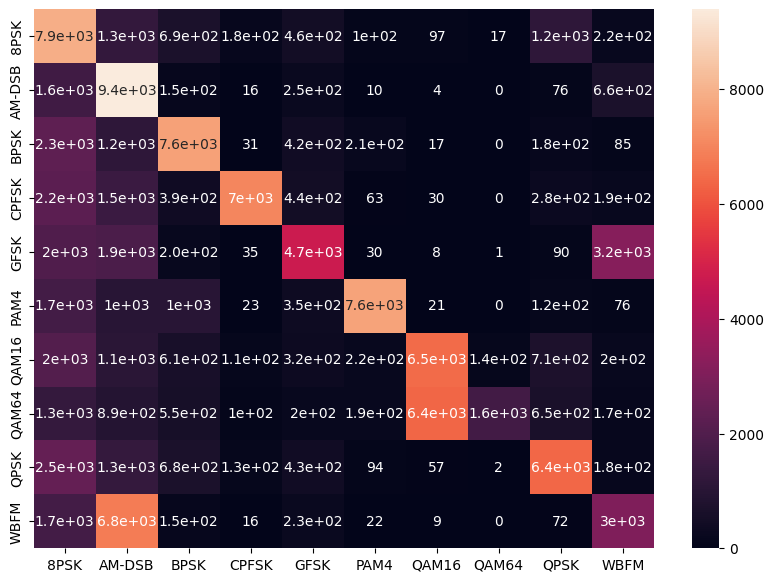

SNR: -20 -- Overall test accuracy: 0.10562799141772569
SNR: -18 -- Overall test accuracy: 0.11303191489361702
SNR: -16 -- Overall test accuracy: 0.11038416373091763
SNR: -14 -- Overall test accuracy: 0.1272209185383842
SNR: -12 -- Overall test accuracy: 0.14612705257920053
SNR: -10 -- Overall test accuracy: 0.19104876419505679
SNR: -8 -- Overall test accuracy: 0.24983333333333332
SNR: -6 -- Overall test accuracy: 0.3373473541383989
SNR: -4 -- Overall test accuracy: 0.522512045190231
SNR: -2 -- Overall test accuracy: 0.6469809760132341
SNR: 0 -- Overall test accuracy: 0.7277832837793194
SNR: 2 -- Overall test accuracy: 0.7526342197691922
SNR: 4 -- Overall test accuracy: 0.7779613414835619
SNR: 6 -- Overall test accuracy: 0.7981497056349874
SNR: 8 -- Overall test accuracy: 0.7878787878787878
SNR: 10 -- Overall test accuracy: 0.7823997348359297
SNR: 12 -- Overall test accuracy: 0.7817872340425532
SNR: 14 -- Overall test accuracy: 0.7921385742838108
SNR: 16 -- Overall test accuracy: 0.7789

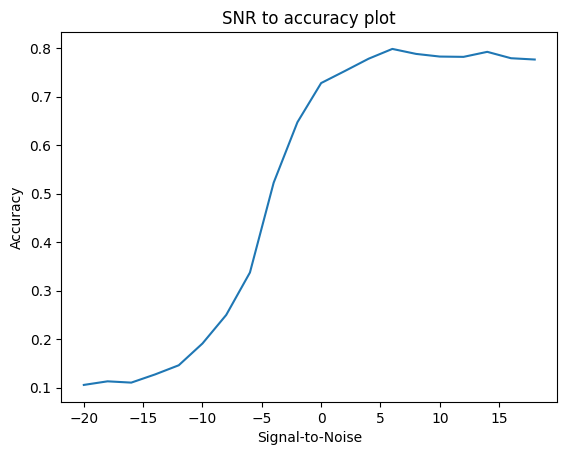

In [12]:
reload_module("deployment_tools")
from deployment_tools import to_tf_lite, predict_tflite

representative_ds = splitted_radioml_ds.train.data[:4000].astype(np.float32)
model_tflile = to_tf_lite(model_path, apply_quantization=True, representative_ds=representative_ds)

cm_test_tflite, cls_to_acc_test_tflite = metric_evaluation(
    model_tflile,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite = snr_to_metric_evaluation(
    model_tflile,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite)

In [13]:
interpreter = tf.lite.Interpreter(model_content=model_tflile)
print(interpreter.get_input_details()[0])
print(interpreter.get_output_details()[0])

{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 128,   2], dtype=int32), 'shape_signature': array([ -1, 128,   2], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0004541363741736859, -4), 'quantization_parameters': {'scales': array([0.00045414], dtype=float32), 'zero_points': array([-4], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 53, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [ ]:
from deployment_tools import deploy_model_tflite

deploy_model_tflite(
    model_tflile,
    test_data=splitted_radioml_ds.test.data,
    test_labels=splitted_radioml_ds.test.labels,
    model_name=model_name,
    classes=radioml_ds.get_modulations(),
    epsilon=20,
    apply_quantization=True,
    arena_size=200_000, 
    create_cfu_playground_proj=True
)

[debug] Export test data


0it [00:00, ?it/s]

11it [00:00, 1542.02it/s]
